In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platereader as pr

/Users/anton/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [95]:
victor3 = pr.load_victor3('./20161121-victor3-od600-calibration.xls')
spectra = pr.load_spectramax('./20161121-spectramax-od600-calibration.xml')

WARNING *** file size (27823) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


We grew MG1655 to overnight and made parallel dilutions of factor 2. Each sample was ODed on both benchtop spectrophotometers, and then three 200ul aliquots of each dilution were plated and the plates read on both the Victor3 and SpectraMax plate readers.

In [25]:
spec = pd.read_csv('./20161121-spec-data.csv')
spec

,Dilution,Volume,1,2
0,Blank,0.000000,0.00,0.00
1,1,1.000000,NaN,NaN
2,2,0.500000,NaN,NaN
3,4,0.250000,1.41,1.42
4,8,0.125000,0.78,0.79
5,16,0.062500,0.41,0.41
6,32,0.031250,0.21,0.21
7,64,0.015625,0.10,0.11
8,128,0.007812,0.07,0.08
9,256,0.003906,0.03,0.02


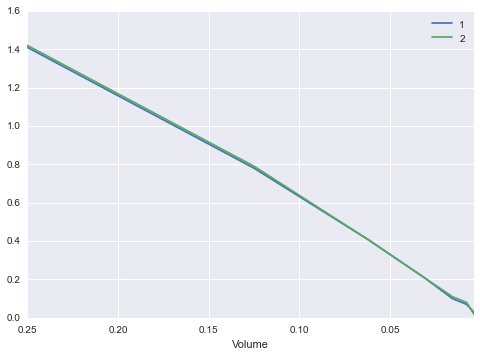

In [28]:
spec.ix[3:,['Volume','1','2']].plot(x='Volume')

In [43]:
spec_long = pd.melt(spec, id_vars='Volume', var_name='Spec', value_name='OD', value_vars=['1','2']).dropna()

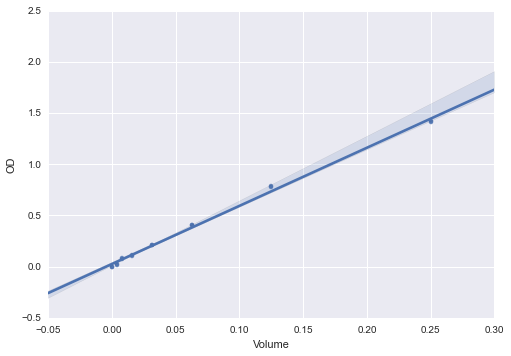

In [57]:
sns.regplot(x='Volume', y='OD', data=spec_long)

In [58]:
np.polyfit(spec_long['Volume'], spec_long['OD'], 1)

array([ 5.68445589,  0.02562212])

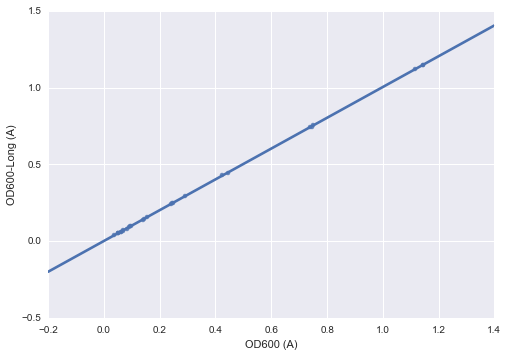

In [68]:
sns.regplot(x='OD600 (A)', y='OD600-Long (A)',
            data=victor3[victor3['Repeat'] == 1].pivot('Well', 'Measurement', 'Data'))

In [96]:
labels = pr.blank_plate_labels()
_, labels.ix[0:3,0:9] = np.mgrid[0:3,0:9]
labels = 1. / 2**labels

In [102]:
victor3 = pr.label(victor3, labels)
victor3['Label'] = victor3['Label'].astype(np.float)

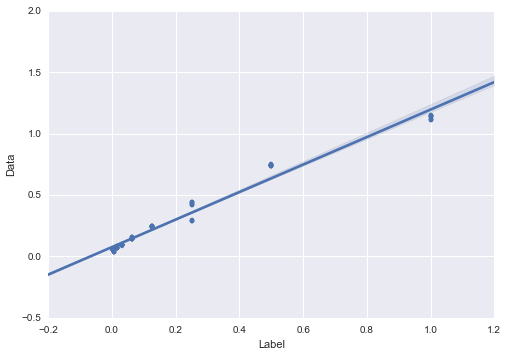

In [103]:
sns.regplot(x='Label', y='Data', data=victor3)

In [104]:
spectra = pr.label(spectra, labels)
spectra['Label'] = spectra['Label'].astype(np.float)

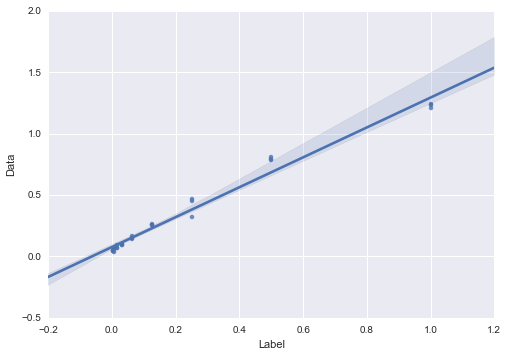

In [107]:
sns.regplot(x='Label', y='Data', data=spectra[spectra['Wavelength'] == 600])

In [118]:
v3_mean = victor3.ix[victor3['MeasurementCount'] == 1].groupby('Label').mean().reset_index()

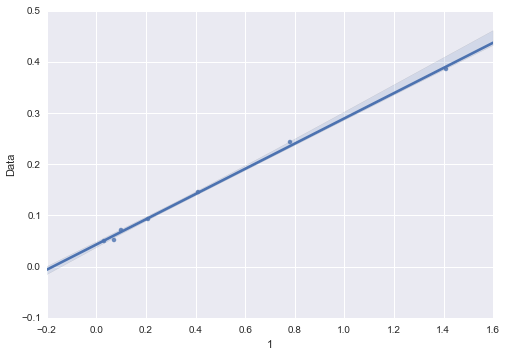

In [157]:
v3_merged = pd.merge(spec, v3_mean[['Label','Data']], left_on='Volume', right_on='Label').dropna()
sns.regplot(x='1', y='Data', data=v3_merged)
v3_coeffs = np.polyfit(v3_merged['Data'], v3_merged['1'], 1)

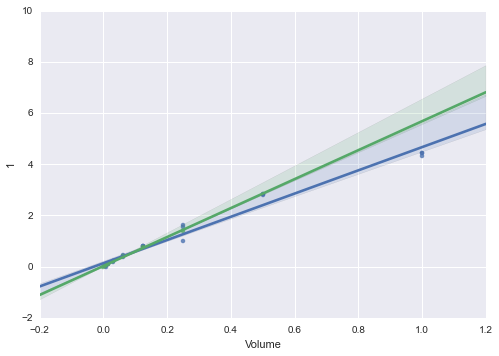

In [167]:
victor3['OD'] = victor3['Data'] * v3_coeffs[0] + v3_coeffs[1]
sns.regplot('Label', 'OD', victor3.ix[victor3['MeasurementCount'] == 1,['Label','OD']])
sns.regplot('Volume', '1', spec)

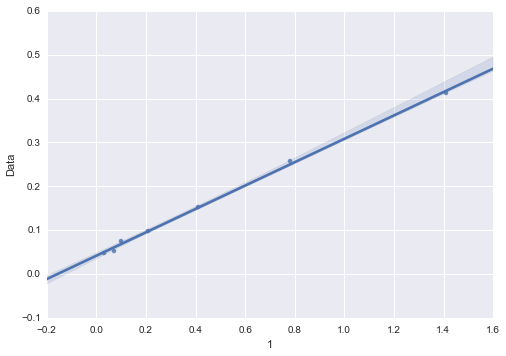

In [145]:
spectra_mean = spectra.ix[spectra['Wavelength'] == 600].groupby('Label').mean().reset_index()
spectra_merged = pd.merge(spec, spectra_mean[['Label','Data']], left_on='Volume', right_on='Label').dropna()

sns.regplot(x='1', y='Data', data=spectra_merged)
spectra_coeffs = np.polyfit(spectra_merged['1'], spectra_merged['Data'], 1)

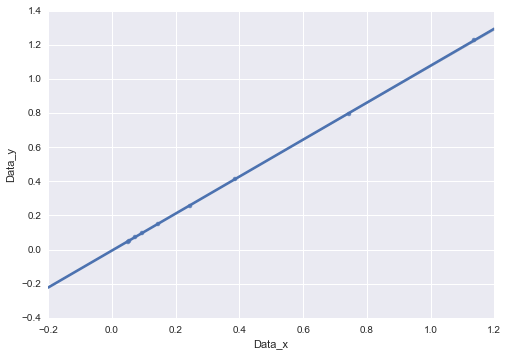

In [143]:
sns.regplot(x='Data_x', y='Data_y', data=pd.merge(v3_mean, spectra_mean, on='Label'))